# This notebook is dedicated to EDA

Importing useful libraries and main data

In [52]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
sb.set()

# data = pd.read_csv("cleaned_data.csv")
vg_sales = pd.read_csv("Final Data.csv")

vg_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61267 entries, 0 to 61266
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          61267 non-null  int64  
 1   Name          61267 non-null  object 
 2   Platform      61267 non-null  object 
 3   Year          56554 non-null  float64
 4   Genre         61267 non-null  object 
 5   Publisher     61267 non-null  object 
 6   Developer     61267 non-null  object 
 7   Critic_Score  6551 non-null   float64
 8   User_Score    402 non-null    float64
 9   NA_Sales      13656 non-null  float64
 10  PAL_Sales     14020 non-null  float64
 11  JP_Sales      7672 non-null   float64
 12  Other_Sales   16365 non-null  float64
 13  Global_Sales  20302 non-null  float64
dtypes: float64(8), int64(1), object(5)
memory usage: 6.5+ MB


## 1. things to note:
1. we want to use Platform, Genre, critic_score, User_score, NA_Sales, PAL_Sales, JP_Sales and Other_Sales to predict Global_Sales
2. there are many Null data points. what are we going to do about those?

vg_critic score and vg_user_score has a lot of null values. vg_critic score has around 60% of Null Values . Therefore it could be possibel to use Missing forest to fill the null values. As for vg_user_score we have decided to drop the entire column as there are too many null values.

In [53]:
# filling out the missing values using missforest
# from missingpy import MissForest
# imputer = MissForest()
# x = data["vg_critic_score"]

Since there are a lot of datapoints that have null values and we feel that we don't have enoug indicators, we have decided to merge the dataset with another dataset (metaCritic.csv)

Importing the new dataset...

In [54]:
metaCritic = pd.read_csv("meta_critic.csv")
metaCritic.head()

,name,platform,release_date,summary,meta_score,user_review
0,The Legend of Zelda: Ocarina of Time,Nintendo 64,"November 23, 1998","As a young boy, Link is tricked by Ganondorf, ...",99,9.1
1,Tony Hawk's Pro Skater 2,PlayStation,"September 20, 2000",As most major publishers' development efforts ...,98,7.4
2,Grand Theft Auto IV,PlayStation 3,"April 29, 2008",[Metacritic's 2008 PS3 Game of the Year; Also ...,98,7.7
3,SoulCalibur,Dreamcast,"September 8, 1999","This is a tale of souls and swords, transcendi...",98,8.4
4,Grand Theft Auto IV,Xbox 360,"April 29, 2008",[Metacritic's 2008 Xbox 360 Game of the Year; ...,98,7.9


Change the column of user_review in metaCritic CSV to meta_UserReview. The following columns are also changed so that merging could be done later. These columns are name and platform.

In [55]:
metaCritic.rename(columns={'user_review':'meta_UserReview','name':'Name','platform':'Platform'},inplace=True)

The user_score column and critic score in vgSales.csv would be changed to vg_user_score and vg_critic_score to so that the columns are clearly identified later in the model.

In [56]:
vg_sales.rename(columns={'User_Score':'vg_user_score','Critic_Score':'vg_critic_score','Rank':'vg_Rank'},inplace=True)
vg_sales['Platform'].unique()

array(['Series', 'All', 'Wii', 'NS', 'NES', 'PC', 'GB', 'DS', 'X360',
       'SNES', 'PS3', 'PS4', '3DS', 'PS2', 'GBA', 'GEN', 'N64', 'PS',
       'XOne', 'WiiU', 'XB', 'PSP', '2600', 'GC', 'GBC', 'iOS', 'PSN',
       'PSV', 'DC', 'XBL', 'SAT', 'SCD', 'PS5', '3DO', 'WS', 'Amig', 'VC',
       'NG', 'WW', 'PCE', 'GG', 'OSX', 'PCFX', 'Mob', 'And', 'Ouya',
       'DSiW', 'MS', 'DSi', 'VB', 'Linux', 'MSD', 'C128', 'AST', 'Lynx',
       '7800', '5200', 'S32X', 'MSX', 'FMT', 'ACPC', 'C64', 'BRW', 'AJ',
       'ZXS', 'NGage', 'GIZ', 'WinP', 'iQue', 'Arc', 'ApII', 'Aco',
       'BBCM', 'TG16', 'CDi', 'CD32', 'XS', 'CV', 'OR', 'Int'],
      dtype=object)

## 2. things to compare:
1. genre vs global sales
2. platform vs global sales (we will remove the platforms that are small, so that we can focus on the bigger picture)
3. correlation between regional sales vs platform (is there a region that likes a particular platform?)
4. correlation between regional sales vs genre (is there a region that likes a particular genre?)
5. correlation between regional sales vs global sales

In [57]:
# dataset to be merged
temp =metaCritic[['Name','Platform','meta_score','meta_UserReview']]
array = temp['Platform'].unique()
print(array)

[' Nintendo 64' ' PlayStation' ' PlayStation 3' ' Dreamcast' ' Xbox 360'
 ' Wii' ' Xbox One' ' PC' ' Switch' ' PlayStation 2' ' PlayStation 4'
 ' GameCube' ' Xbox' ' Wii U' ' Game Boy Advance' ' 3DS' ' Xbox Series X'
 ' DS' ' PlayStation Vita' ' PlayStation 5' ' PSP' ' Stadia']


In [58]:
# dictonary that contains the keywords that needs to be swapped
conversion ={
    ' Nintendo 64':'N64' ,
    ' PlayStation': 'PS' ,
    ' PlayStation 3': 'PS3', 
    ' Dreamcast': 'DC',
    ' Xbox 360':'X360',
    ' Wii':'Wii',
    ' Xbox One':'XOne',
    ' PC' : 'PC',
    ' Switch': 'NS',
    ' PlayStation 2': 'PS2',
    ' PlayStation 4': 'PS4',
    ' GameCube': 'GCN',
    ' Xbox': 'XB',
    ' Wii U': 'WiiU',
    ' Game Boy Advance': 'GBA',
    ' 3DS': '3DS',
    ' Xbox Series X': 'XSX',
    ' DS': 'DS',
    ' PlayStation Vita': 'PSV',
    ' PlayStation 5': 'PS5',
    ' PSP': 'PSP',
    ' Stadia': 'PC',    
 }
 
temp = temp.replace({'Platform': conversion})

In [51]:
# exporting into csv

merged_dataSet = pd.merge(temp,vg_sales,on=["Name","Platform"])
merged_dataSet.to_csv('merged_dataSet.csv')

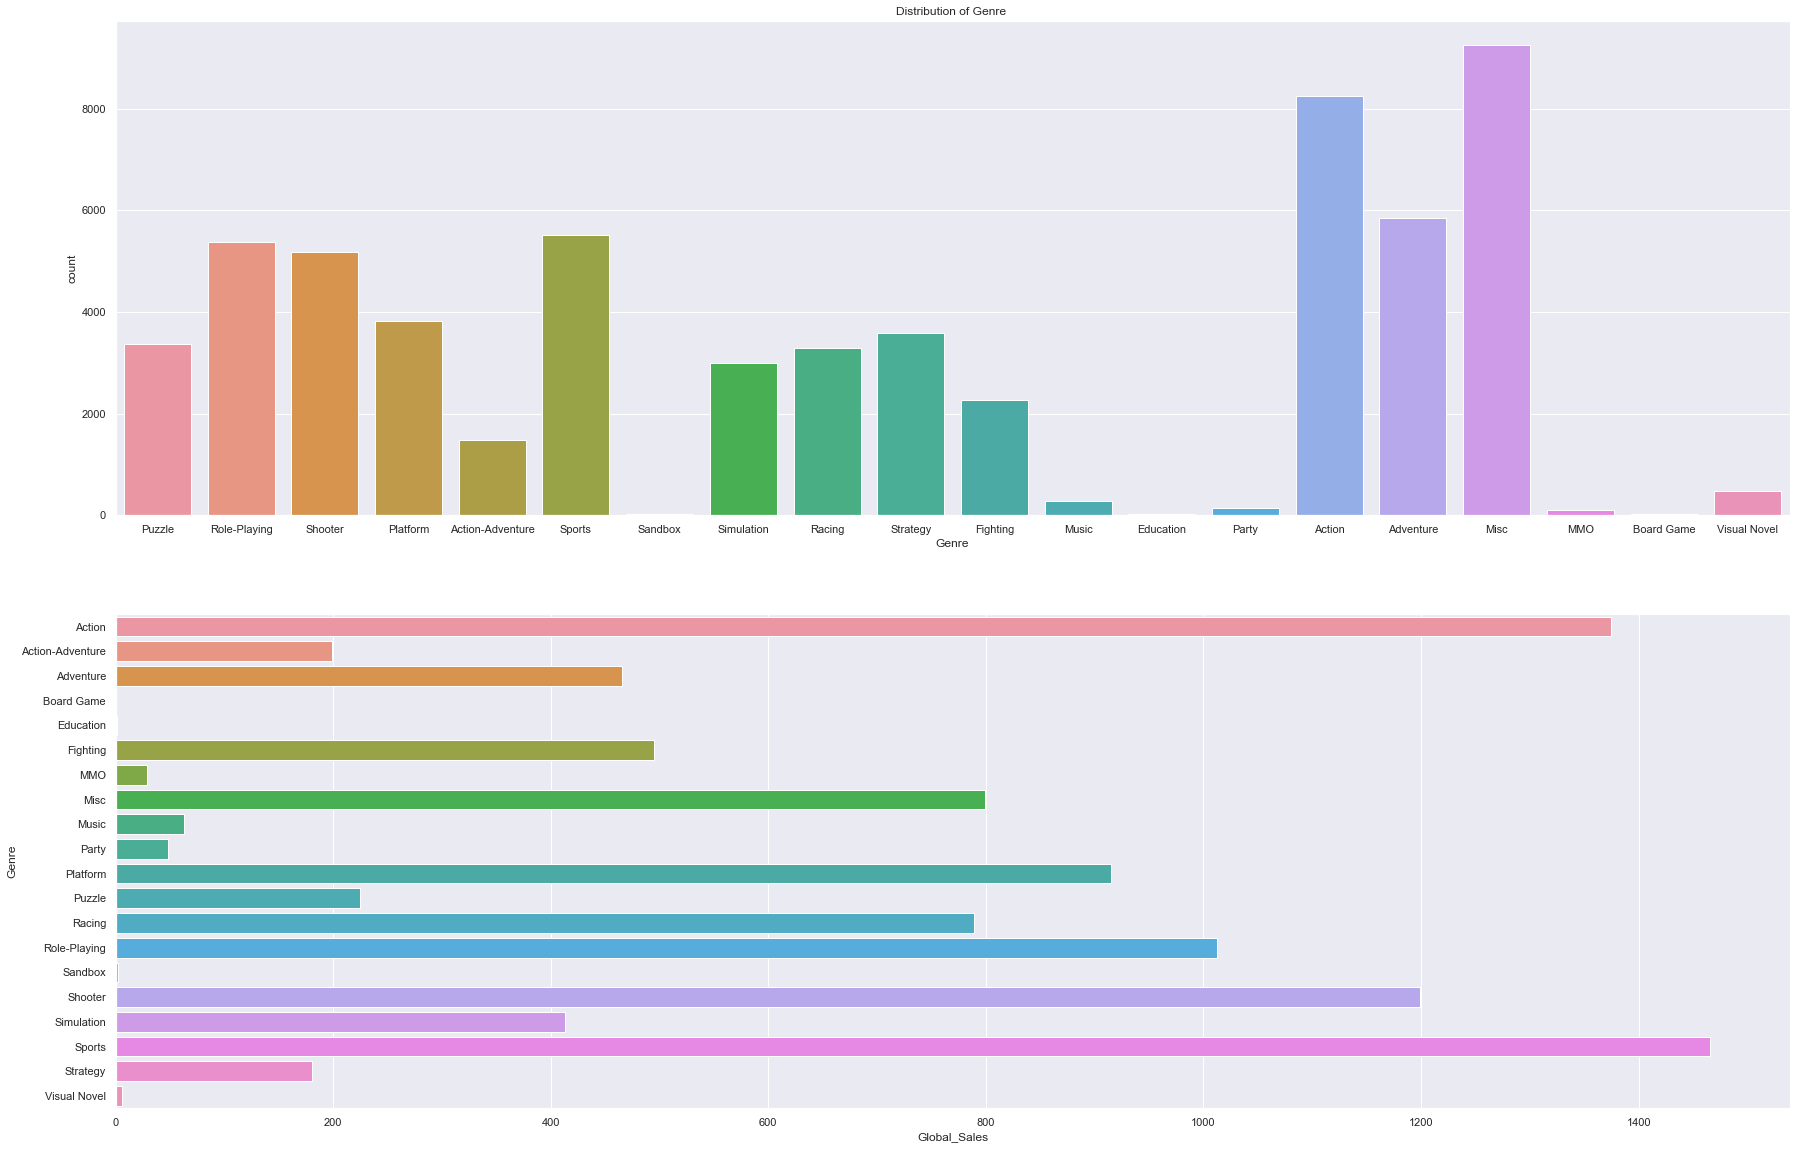

In [31]:
#genre vs global sales
f,axes = plt.subplots(2,1,figsize=(30,20))
axes[0].set_title("Distribution of Genre ")
sb.countplot(x="Genre", data = data , ax = axes[0])

genereSale = data.groupby('Genre')['Global_Sales'].sum()
p = sb.barplot(y=genereSale.index, x=genereSale,ax=axes[1])

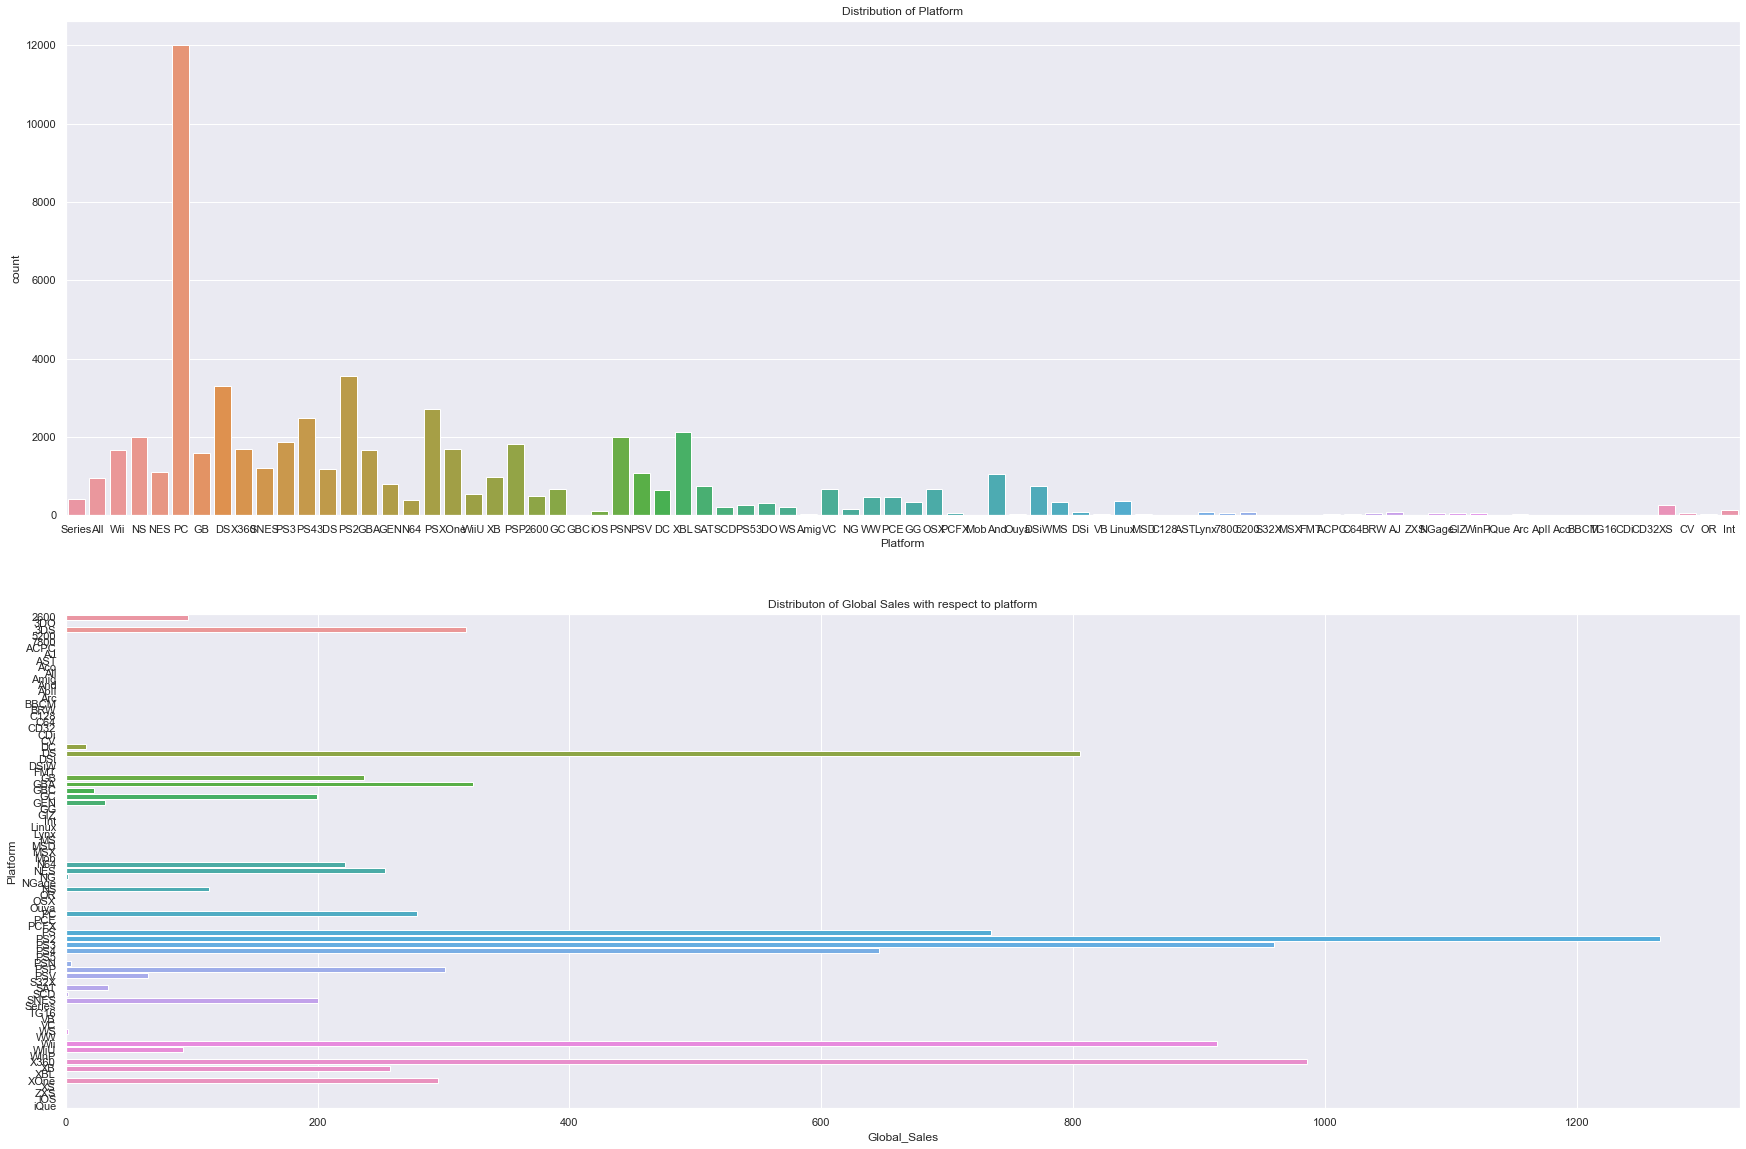

In [32]:
#platform vs global sales
f,axes = plt.subplots(2,1,figsize=(30,20))
axes[0].set_title("Distribution of Platform")
sb.countplot(x="Platform", data = data , ax = axes[0])

platformSale = data.groupby('Platform')['Global_Sales'].sum()
axes[1].set_title("Distributon of Global Sales with respect to platform")
p = sb.barplot(y=platformSale.index, x=platformSale,ax=axes[1])

In [33]:
#correlation between regional sales and platform

In [34]:
#Identifying top games per year based on the different predictors

top_game = data.groupby('Year')['Global_Sales']
top_game.head()


0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
19402   NaN
25524   NaN
26236   NaN
41039   NaN
51267   NaN
Name: Global_Sales, Length: 243, dtype: float64

## 3. main issues
1. we realised that we don't have a lot of indicators to work with, so we merged another dataset and cleaned it (can add in the cleaning code here a bit ah). this gives us more indicators to work with.

## 4. more things to compare:
1. correlation between meta score and all sales (regional + global) -> is meta score a good indicator of sales in general?
2. correlation between user review and all sales (regional + global) -> is user review a good indicator of sales in general?

## 5. end of EDA
- we decide on what indicators we are using, based on the results that we get from the EDA

In [35]:
ml = data
ml.drop("Genre",axis =1,inplace = True)
ml.drop("vg_user_score",axis =1,inplace = True)
ml.head()
ml.to_csv('ml_dataSet.csv')



KeyError: "['vg_user_score'] not found in axis"